In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from matplotlib.image import imread

In [2]:
def my_pinv(X,rank):
    print('rank',rank)
    U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    Σ[rank:] = 0.0
    return Vh.T.conj().dot(np.linalg.pinv(np.diag(Σ))).dot(U.T.conj())

In [3]:
# Load video
mov = np.array([imread('highway/input/in00' + '0000'[:4 - len(str(k))] + str(k) + '.jpg').mean(axis=2) for k in range(1,1701)])

# Shrink for easier processing
n_frames, height, width = mov.shape
shrink_factor = 2
X = np.reshape(mov[:,::shrink_factor,::shrink_factor],(n_frames,height*width//shrink_factor**2)).T
X1 = X[:,150:190]
X2 = X[:,151:191]
X_short = X[:,400:441]
μ1 = np.mean(X1,axis=1)

In [4]:
dt = 1.0
# Create data matrices of DMD

# SVD and rank-50 truncation
r = 39 # rank truncation
U, Σ, Vh = svds(X1,r)
V = Vh.conj().T
Ur = U[:,:r]
Σr = Σ[:r]
Vr = V[:,:r]

# Build Ã and DMD modes
Ã = Ur.conj().T.dot(X2).dot(Vr) / Σr
λ,W = np.linalg.eig(Ã)
Φ = (X2.dot(Vr) / Σr).dot(W)

# DMD spectra
ω = np.log(λ)/dt

loc_min = np.argmin(np.abs(ω)) # location of stationary mode

In [5]:
dmd_cent = {}

dt = 1.0
# Create data matrices of DMD
μ = np.mean(X_short,axis=1)
μ1 = np.mean(X1,axis=1)
μ2 = np.mean(X2,axis=1)
X1cent = X1 - μ1[:,np.newaxis]
X2cent = X2 - μ2[:,np.newaxis]

# SVD and rank-50 truncation
dmd_cent['r'] = 38 # rank truncation
dmd_cent['U'], dmd_cent['Σ'], dmd_cent['Vh'] = svds(X1cent,dmd_cent['r'])
dmd_cent['V'] = dmd_cent['Vh'].conj().T
dmd_cent['Ur'] = dmd_cent['U'][:,:dmd_cent['r']]
dmd_cent['Σr'] = dmd_cent['Σ'][:dmd_cent['r']]
dmd_cent['Vr'] = dmd_cent['V'][:,:dmd_cent['r']]

# Build Ã and DMD modes
dmd_cent['Ã'] = dmd_cent['Ur'].conj().T.dot(X2cent).dot(dmd_cent['Vr']) / dmd_cent['Σr']
dmd_cent['λ'],dmd_cent['W'] = np.linalg.eig(dmd_cent['Ã'])
Φcent = (X2cent.dot(dmd_cent['Vr']) / dmd_cent['Σr']).dot(dmd_cent['W'])

# DMD spectra
dmd_cent['ω'] = np.log(dmd_cent['λ']) / dt

In [6]:
# Compute fixed point
A = X2cent @ my_pinv(X1cent,39)
b = μ2 - A.dot(μ1)
c = np.linalg.solve(np.eye(*A.shape)-A,b)

rank 39


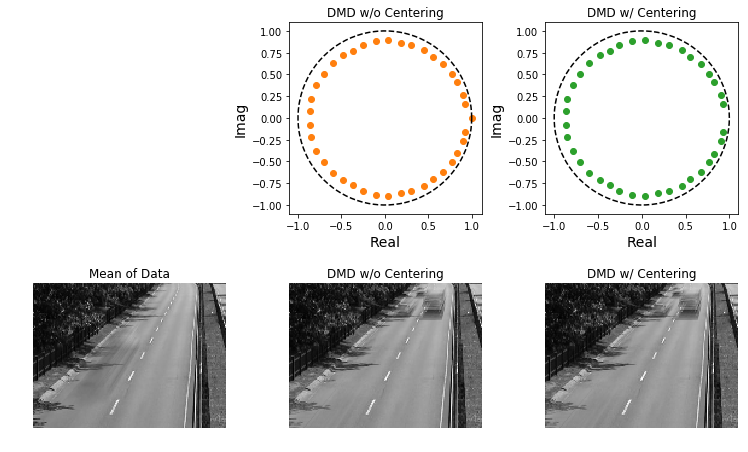

In [7]:
plt.figure(figsize=(10.5,6.5))

plt.subplot(2,3,4)
μ=X_short.mean(axis=1)
mean = μ.reshape((height//shrink_factor,width//shrink_factor))
plt.imshow(mean,cmap='gray')
plt.axis('off')
plt.title('Mean of Data')

plt.subplot(2,3,6)
plt.imshow(c.reshape((height//shrink_factor,width//shrink_factor)),cmap='gray')
plt.axis('off')
plt.title('DMD w/ Centering')

plt.subplot(2,3,5)
loc_min = np.argmin(np.abs(ω)) # location of stationary mode
plt.imshow(np.real(Φ[:,loc_min].reshape((height//shrink_factor,width//shrink_factor))),cmap='gray')
plt.axis('off')
plt.title('DMD w/o Centering')


plt.subplot(2,3,2)
plt.scatter(np.real(λ),np.imag(λ),c='tab:orange')
temp = np.linspace(0,1,100)
x = np.cos(2*np.pi*temp)
y = np.sin(2*np.pi*temp)
plt.plot(x,y, 'k--')
plt.ylabel('Imag',fontsize=14)
plt.xlabel('Real',fontsize=14)
plt.title('DMD w/o Centering')

plt.subplot(2,3,3)
plt.title('DMD w/ Centering')
plt.scatter(np.real(dmd_cent['λ']),np.imag(dmd_cent['λ']),c='tab:green')
temp = np.linspace(0,1,100)
x = np.cos(2*np.pi*temp)
y = np.sin(2*np.pi*temp)
tt = np.linspace(0,2*np.pi,100) 
plt.ylabel('Imag',fontsize=14)
plt.xlabel('Real',fontsize=14)
plt.plot(x,y, 'k--')


plt.tight_layout()

plt.savefig('background.png')